# 2D Plume in Regional Flow (Hunt Solution)

The sketch depicts a vertical line source in an aquifer of infinite extent located at (x,y)=(0,0) some time after constant injection has begun. 

![](huntsetup.png)

For the line source (injection well) whose fluid contribution makes negligible impact on the local hydraulics as depicted in the sketch the initial, boundary, and mass conservation conditions are:

$$C(x,y,0)=0$$
$$C(\pm \infty,\pm \infty,t)=0$$
$$\int_{- \infty}^{\infty}\int_{-\infty}^{\infty}C(x,y,t)dxdy = C_0 Q t$$

A solution obtained by time-convolution of an elementary line source solution (Hunt, 1978) is 

$$C(x,y,t) = \frac{C_0 Q}{4 \pi n L}\frac{1}{\sqrt{D_x D_y}}exp(\frac{x v}{2 D_x})W(a,b)$$

where $W(a,b)$ is the leaky aquifer (Hantush) well function with

$$a=\frac{(x^2+y^2(\frac{D_x}{D_y}))}{4 D_x t}$$

$$b=\frac{\sqrt{(x^2+y^2(\frac{D_x}{D_y})}}{2D_x}$$

The solution is presented in (Bear, 1972) as a convolution integral (eqn. 10.6.38, p. 634) (the end user needs to supply the integration routine); Hunt (1978) noticed that the integral was the leaky well function with appropriate substitutions and completed the solution.

The leaky aquifer function can be evaluated numerically using a recursive definition, or efficient approximations can be used. Listings for these approximations appear below after the references


The solution is applicable for porous media flow, where the velocity (below) is the mean section velocity (seepage velocity divided by the porosity). The solution can also be used with streams and pipes (porosity = 1). Negative values of distance in x-axis would correspond to locations upgradient of the injection location.

Scripts to generate solutions are listed below:

## Leaky Well Function

In [1]:
def wh(u, rho): # Hantush Leaky aquifer well function
    import numpy
    """Returns Hantush's well function values

    Note: works only for scalar values of u and rho

    Parameters:
    -----------
    u : scalar  (u= r^2 * S / (4 * kD * t))
    rho : sclaar (rho =r / lambda, lambda = sqrt(kD * c))
    Returns:
    --------
    Wh(u, rho) : Hantush well function value for (u, rho)
    """
    try:
        u =float(u)
        rho =float(rho)
    except:
        print("u and rho must be scalars.")
        raise ValueError()

    LOGINF = 2
    y = numpy.logspace(numpy.log10(u), LOGINF, 1000)
    ym = 0.5 * (y[:-1]+  y[1:])
    dy = numpy.diff(y)
    wh = numpy.sum(numpy.exp(-ym - (rho / 2)**2 / ym ) * dy / ym)
    return(wh)

## Hunt Solution (Prototype Function)

In [2]:
def chunt(c_injection,q_injection,l_thickness,d_x,d_y,velocity,x_location,y_location,time):
    import math
    rsq = (x_location**2 + (y_location**2)*(d_x/d_y))
    rrr = math.sqrt(rsq)
    aaa = rsq/(4.0*d_x*time)
    bbb = (rrr*velocity)/(2.0*d_x)
#    print(rsq,rrr,aaa,bbb)
    term1 = c_injection*q_injection/(4.0*math.pi*l_thickness)
    term2 = 1.0/(math.sqrt(d_x*d_y))
    term3 = math.exp((x_location*velocity)/(2.0*d_x))
#    term4 = leakyfn(aaa,bbb)
    term4 = wh(aaa,bbb)

    #if term4 <= 0.0: term4 = 0.0
#    print(term1,term2,term3,term4)
    chunt = term1*term2*term3*term4
    return chunt

## Driver Script

In [3]:
# inputs
c_injection = 133
q_injection = 3.66
l_thickness = 1.75
d_x = 0.920
d_y = 0.092
velocity = 0.187
x_location = 123
y_location = 0
time = 36500
scale = c_injection*q_injection
output = chunt(c_injection,q_injection,l_thickness,d_x,d_y,velocity,x_location,y_location,time)
print("Concentration at x = ",round(x_location,2)," y= ",round(y_location,2) ," t= ",round(time,2) ," = ",round(output,3))
#

Concentration at x =  123  y=  0  t=  36500  =  53.424


## Plotting Script

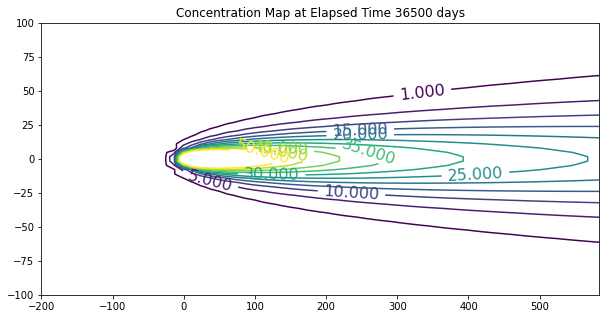

In [4]:
# make a plot
x_max = 200
y_max = 100
# build a grid
nrows = 50   
deltax = (x_max*4)/nrows
x = []
x.append(-x_max)
for i in range(nrows):
    if x[i] == 0.0:
        x[i] = 0.00001
    x.append(x[i]+deltax)

ncols = 50   
deltay = (y_max*2)/(ncols-1)
y = []
y.append(-y_max)
for i in range(1,ncols):
    if y[i-1] == 0.0:
        y[i-1] = 0.00001
    y.append(y[i-1]+deltay)
    
#y

#y = [i*deltay for i in range(how_many_points)] # constructor notation
#y[0]=0.001
ccc = [[0 for i in range(nrows)] for j in range(ncols)]

for jcol in range(ncols):
    for irow in range(nrows):
        ccc[irow][jcol] = chunt(c_injection,q_injection,l_thickness,d_x,d_y,velocity,x[irow],y[jcol],time)
        
#y

my_xyz = [] # empty list
count=0
for irow in range(nrows):
    for jcol in range(ncols):
        my_xyz.append([ x[irow],y[jcol],ccc[irow][jcol] ])
       # print(count)
        count=count+1
        
#print(len(my_xyz))

import pandas
my_xyz = pandas.DataFrame(my_xyz) # convert into a data frame
import numpy 
import matplotlib.pyplot
from scipy.interpolate import griddata
# extract lists from the dataframe
coord_x = my_xyz[0].values.tolist() # column 0 of dataframe
coord_y = my_xyz[1].values.tolist() # column 1 of dataframe
coord_z = my_xyz[2].values.tolist() # column 2 of dataframe
#print(min(coord_x), max(coord_x)) # activate to examine the dataframe
#print(min(coord_y), max(coord_y))
coord_xy = numpy.column_stack((coord_x, coord_y))
# Set plotting range in original data units
lon = numpy.linspace(min(coord_x), max(coord_x), 64)
lat = numpy.linspace(min(coord_y), max(coord_y), 64)
X, Y = numpy.meshgrid(lon, lat)
# Grid the data; use linear interpolation (choices are nearest, linear, cubic)
Z = griddata(numpy.array(coord_xy), numpy.array(coord_z), (X, Y), method='cubic')
# Build the map
fig, ax = matplotlib.pyplot.subplots()
fig.set_size_inches(10, 5)
CS = ax.contour(X, Y, Z, levels = [1,5,10,15,20,25,30,35,40,45,50])
ax.clabel(CS, inline=2, fontsize=16)
ax.set_title('Concentration Map at Elapsed Time '+ str(round(time,1))+' days');


## Spreadsheet Model

A spreadsheet implementation is available at [http://54.243.252.9/ce-5364-webroot/6-Spreadsheets/HuntModel.xlsm](http://54.243.252.9/ce-5364-webroot/6-Spreadsheets/HuntModel.xlsm)  

:::{note}
This model requires Analysis Tool Pack Add-In and the VBA Macro Enabled.
::::

<!--
from scipy import *
from scipy import special
from scipy.special import kn as BesselK
#from scipy.special import expn as ExpInt
from math import sqrt as sqrt
from math import cosh as cosh
from math import log as ln # in python: log(x)=Ln(x)
import numpy

def ExpInt(n,u):

    # n wordt niet gebruikt

    # Fast approximation for Wu according to equation 7a and 7b from Srivastava(1998)
    gamma = 0.5772 # Euler-Macheroni constant

    # Wu for u<1
    u0  = numpy.where(u<1.0,u,1) # u=1 is just a dummy to make ln() work on all values
    Wu0 = numpy.lib.scimath.log(numpy.exp(-gamma)/u0) + 0.9653*u - 0.1690*u0**2

    #Wu for u>=1
    u1 = numpy.where(u>=1.0,u,1) # u=1 is just a dummy to make ln() work on all values
    Wu1 = 1/(u1*numpy.exp(u1))*(u1+0.3575)/(u1+1.280)

    # combine Wu0 and Wu1
    Wu = numpy.where(u<1.0,Wu0,Wu1)
    return Wu

def func_F(rho,tau):
# func_F is a fast approximation of Hantush well function W

    # Calculate parameter w
    w = (ExpInt(1,rho)-BesselK(0,rho))/(ExpInt(1,rho)-ExpInt(1,rho/2))

    # Calculate F(rho,tau)
    if tau <= 0:
        F = w*ExpInt(1,rho/2*e**(-tau))-(w-1)*ExpInt(1,rho*cosh(tau))
    else:
        F = 2*BesselK(0,rho) - w*ExpInt(1,rho/2*e**tau) + (w-1)*ExpInt(1,rho*cosh(tau))

    # return calculated value of F(rho,tau)
    return F
-->

## References

1. Hunt, B. (1978) Dispersive sources in uniform ground water flow. Journal of the Hydraulics Division, 104 (HY1), 75-85. 
<!--2. [**SSANTS2.xlsm** (Excel Macro Sheet(s)) - Choose Tabsheet **2D????**](http://54.243.252.9/ce-5364-webroot/ce5364notes/chapters/7analyticalmodels/SSANTS2.xlsm)-->
3. [Yuan, D, (1995)  *Accurate approximations for one-, two-, and three-dimensional groundwater mass transport from an exponentially decaying contaminant source.* MS Thesis, Department of Civil and Environmental Engineering, University of Houston. ](http://54.243.252.9/about-me-webroot/about-me/MyWebPapers/thesis/yuan_thesis/Groundwater_transport.pdf)
4. [Chuang, Lu-Chia, (1998) *A guidance system for choosing analytical contaminant transport models.* Doctoral Dissertation, Department of Civil and Environmental Engineering, University of Houston, Houston, Texas. 222p.](http://54.243.252.9/about-me-webroot/about-me/MyWebPapers/thesis/ants_dissertation/Luke_Chuang.pdf)
5. [Analytical solutions for one-, two-, and three-dimensional solute transport in ground-water systems with uniform flow
Open-File Report 89-56](https://pubs.usgs.gov/publication/ofr8956)
6. [Analytical solutions for one-, two-, and three-dimensional solute transport in ground-water systems with uniform flow
Techniques of Water-Resources Investigations 03-B7 (supercedes above reference)](https://pubs.usgs.gov/publication/twri03B7)

## Useful Code Listings

**Polynomial Approximation**

The approximations below are coded in python, and can convert to spreadsheet using VBA fairly easily. These are based on polynomial approximations in:

Abramowitz, M. and I.A. Stegun, 1964. Handbook of Mathematical Functions with Formulas, Graphs, and Mathematical Tables. U.S. Department of Commerce, National Bureau of Standards, Applied Mathematics Series, Vol 55.

And seem to produce nearly the same results as the recursive version above.

In [5]:
#######################
# Theis Well Function # 
#######################
def wellfn(u):
    import math
    if ((u >= 0) and (u <=1)):
# polynomial approximation constants
        a0 = -0.57721566
        a1 =  0.99999193
        a2 = -0.24991055
        a3 =  0.05519968
        a4 = -0.00976004
        a5 =  0.00107857
        wellfn = -math.log(u) + a0 + a1*u + a2*u**2 + a3*u**3 + a4*u**4 + a5*u**5
        return(wellfn)
    elif ((u >1)):
# polynomial approximation constants
        a1 =  8.5733287401
        a2 = 18.0590169730
        a3 =  8.6347608925
        a4 =  0.2677737343
        b1 =  9.5733223454
        b2 = 25.6329561486
        b3 = 21.0996530827
        b4 =  3.9584969228
        frac1 = u**4 + a1*u**3 + a2*u**2 + a3*u + a4
        frac2 = u**4 + b1*u**3 + b2*u**2 + b3*u + b4
        frac3 = u*math.exp(u)
        wellfn = (frac1/frac2)/frac3
        return(wellfn)
    else:
        print('error in wellfn')
        wellfn = -999.0
        return(wellfn)

#######################
# Leaky Well Function #
#######################
def leakyfn(u,v):
    import math
    import numpy
    from scipy.special import kn as besselK
    from scipy.special import iv as besselI
# finite series recursion constants
    c12 =  0.0277777777777778
#
    c14 = -0.00347222222222222
    c15 =  0.00173611111111111
#
    c17 =  0.000416666666666667
    c18 = -0.000138888888888889
    c19 =  0.0000694444444444444
#
    c21 = -0.0000462962962962963
    c22 =  0.0000115740740740741
    c23 = -3.85802469135802E-06
    c24 =  1.92901234567901E-06
#
    c26 =  4.72411186696901E-06
    c27 = -9.44822373393802E-07
    c28 =  2.3620559334845E-07
    c29 = -7.87351977828168E-08
    c30 =  3.93675988914084E-08
#
    c32 = -4.42885487528345E-07
    c33 =  7.38142479213908E-08
    c34 = -1.47628495842782E-08
    c35 =  3.69071239606954E-09
    c36 = -1.23023746535651E-09
    c37 =  6.15118732678257E-10
#
# entry point 
    a3 = (v**2)/4  
# if leakance term is negligible, then return well function
    if (a3 == 0) :
        leakyfn = wellfn(u)
        return(leakyfn)
# if leakance/time term is large enough, then return besselKo
    if (a3/u > 5) :
        leakyfn = 2*besselK(0,v)
        return(leakyfn)
#  }
# finite series approximation for u>1, v<=2
    if ((u >= 1) and (v <= 2)) :
    # recursion terms built by-hand (ported from SSANTS)
        g11 = c12*a3
        g12 = c14*(a3**2)/(u)
        g21 = c15*(a3**2)
        g22 = c17*(a3**3)/(u**2)
        g23 = c18*(a3**3)/(u)
        g31 = c19*(a3**3)
        g32 = c21*(a3**4)/(u**3)
        g33 = c22*(a3**4)/(u**2)
        g34 = c23*(a3**4)/(u)
        g41 = c24*(a3**4)
        g42 = c26*(a3**5)/(u**4)
        g43 = c27*(a3**5)/(u**3)
        g44 = c28*(a3**5)/(u**2)
        g45 = c29*(a3**5)/(u)
        g51 = c30*(a3**5)
        g52 = c32*(a3**6)/(u**5)
        g53 = c33*(a3**6)/(u**4)
        g54 = c34*(a3**6)/(u**3)
        g55 = c35*(a3**6)/(u**2)
        g56 = c36*(a3**6)/(u)
        g61 = c37*(a3**6)
    # sum them up!
        a34list = [g11,g12,g21,g22,g23,g31,g32,g33,g34,g41,g42,g43,g44,g45,g51,g52,g53,g54,g55,g56,g61]
        a34 = numpy.sum(a34list)
        a35 = a34*math.exp(-u)
        a36 = a3/u
        a37 = besselI(v,0)
        a38 = wellfn(u)*a37
        a39 = 0.5772 + math.log(a36) + wellfn(a36) - a36 +(besselI(0,v)-1)/u
        a40 = a39*math.exp(-u)
        leakyfn = a38 - a40 + a35
        leakyfn=abs(leakyfn)
        return(leakyfn)
# finite series approximation for u<=1, v<=2
    if ((u <= 1) and (v <= 2)) :
    # recursion terms built by-hand (ported from SSANTS)
        g11 = c12*a3
        g12 = c14*(a3)/(u**-1)
        g21 = c15*(a3**2)
        g22 = c17*(a3)/(u**-2)
        g23 = c18*(a3**2)/(u**-1)
        g31 = c19*(a3**3)
        g32 = c21*(a3)/(u**-3)
        g33 = c22*(a3**2)/(u**-2)
        g34 = c23*(a3)/(u**-1)
        g41 = c24*(a3**4)
        g42 = c26*(a3)/(u**-4)
        g43 = c27*(a3**2)/(u**-3)
        g44 = c28*(a3**3)/(u**-2)
        g45 = c29*(a3**4)/(u**-1)
        g51 = c30*(a3**5)
        g52 = c32*(a3)/(u**-5)
        g53 = c33*(a3**2)/(u**-4)
        g54 = c34*(a3**3)/(u**-3)
        g55 = c35*(a3**4)/(u**-2)
        g56 = c36*(a3**5)/(u**-1)
        g61 = c37*(a3**6)
    # sum them up!  
        a70list = [g11,g12,g21,g22,g23,g31,g32,g33,g34,g41,g42,g43,g44,g45,g51,g52,g53,g54,g55,g56,g61]
        a70 = numpy.sum(a70list)
        a71 = u*a70
        a72 = a3/u
        a73 = 0.5772+math.log(u)+wellfn(u)-u+(besselI(0,v)-1)/(a72)
        a74 = a73*math.exp(-a72)
        a75 = besselI(0,v)*wellfn(a72)
        a76 = a75 - a74 + a71
        a77 = 2*besselK(0,v)
        leakyfn = (a77-a76)
        return(leakyfn)
# approximation for v > 2
    if (v > 2) :
        term1 = math.sqrt(pi/(2*v))
        term2 = math.exp(-v)
        term3 = -(v-2*u)/(2*math.sqrt(u))
        term4 = math.erfc(term3)
        leakyfn = term1*term2*term4
        return(leakyfn)
    else:
        print('error in leakyfn')
        leakyfn = -999.0
        return(leakyfn)